## Project Motivation

While almost everybody loves music, people also have varying preferences for what they like to listen to. It is this variation in preference that makes some songs popular hits that are always on the radio and makes other songs appeal to more of a niche audience. The aim of this article is to investigate the underlying factors that make particular songs popular and validate whether audio and lyrical features of a song can explain its success. We will outline the process we have taken beginning from data collection all the way through model building and results.

The project was broken down into these steps:
1. Data collection
2. Exploratory data analysis
3. Text analysis and natural language processing
4. Model building and hyperparameter tuning
5. Results and next steps

## Dataset

This project uses data from the [Spotify Hit Predictor Dataset](https://github.com/fortytwo102/the-spotify-hit-predictor-dataset). This dataset was scraped using the Spotify API, and hit songs were identified using the Billboard Hot 100 API. We are using a segment of the dataset, as we will only be investigating songs that were produced after the year 2000, as we want to train our model on more recent data (the dataset goes back to the 1950s). Our dataset is roughly 12,000 rows (each row represents a song). The dataset contains Spotify Echo Nest features and limited metadata about the song. We will use the Echo Nest features to help us predict songs. Below are the features we will use (specific definitions can be found [here](https://github.com/fortytwo102/the-spotify-hit-predictor-dataset)):  
1. Danceability
2. Energy
3. Key
4. Loudness
5. Mode
6. Speechiness
7. Acousticness
8. Instrumentalness
9. Liveness
10. Valence
11. Tempo

In addition to evaluating Echo Nest features, we also wanted to evaluate how a song's lyrics impact its popularity. To do this, we scraped lyrics using the Genius API for as many songs in our dataset that Genius had the lyrics for. For the songs we could not find on Genius, we scraped from AZ Lyrics. Removing songs that we could not find lyrics for left us with about 10,000 songs. The lyrical features we will derive are:
1. Repetitiveness
2. Average word length
3. Word count
4. Word count/duration
5. Repetitiveness*duration
6. Repetitiveness*word count
7. Polarity (how positive or negative a song is)
8. Average Commonness Score
9. Topic Model Topics

Finally, our target variable is a binary indicator where a 1 represents a song that has made it at least once to the Billboard Hot 100 and a 0 represents a song that did not make it (a hit vs. a flop). 

## EDA

### Target ratio

The distribution of our dataset is about 60% hit and 40% flop with about 6,000 hits and about 4,000 flops. 


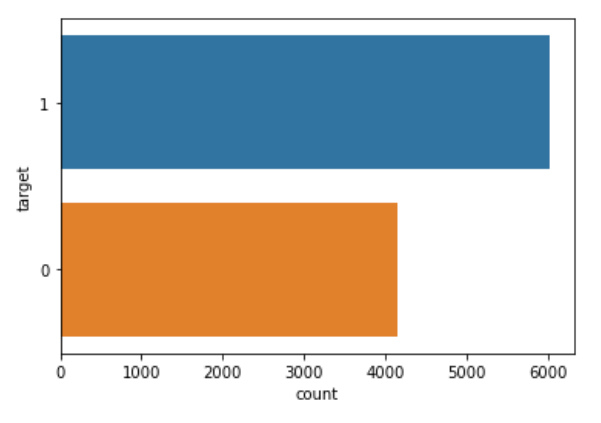

### Feature Distribution

Danceability and Valence seem to be the only normally distributed features. Many of the accoustic features are skewed left or right.
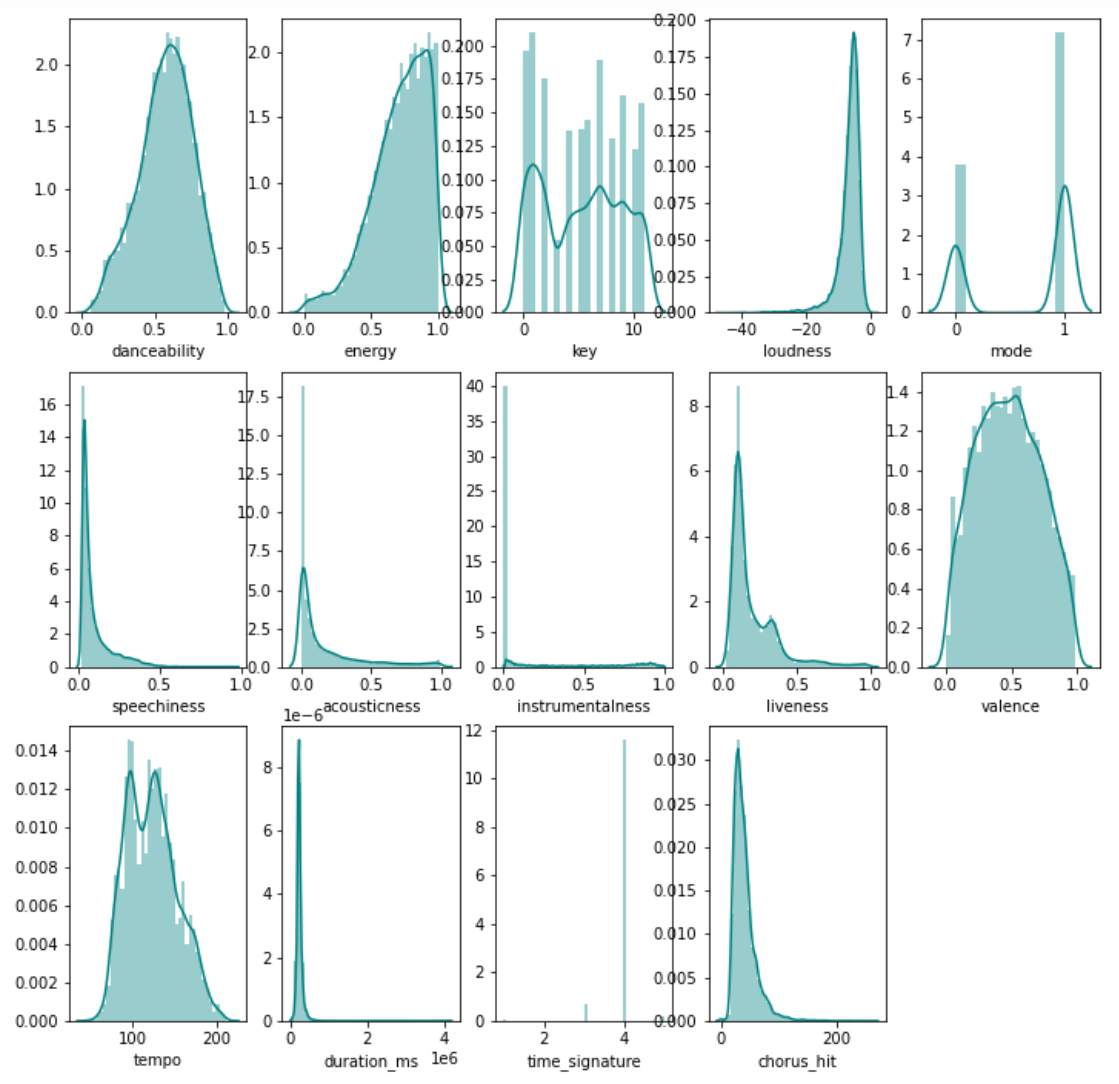


### Heatmap

In order to evaluate the correlations between each of the features, we use a heatmap. Energy and accousticness have the highest negative correlation with a value of -0.66. It seems like songs with a more accoustic style tend to lack energy. Conversely, Engergy and loudness have the highest positive correlation with a score of 0.7. It does seem intuitive that the louder the music is, the more energy it will have.


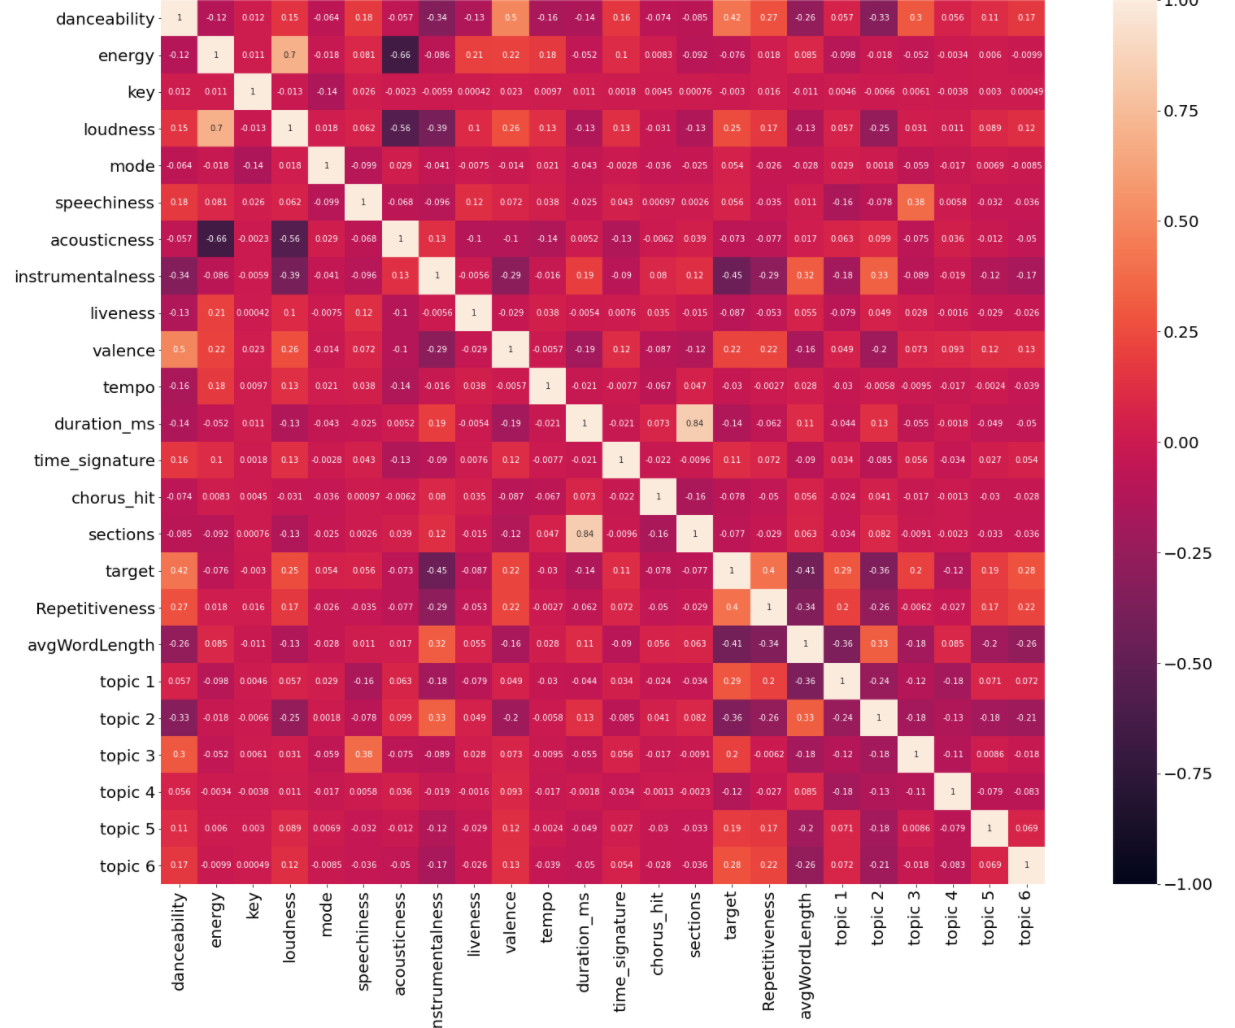

### Relation between duration and the track (*Chart title should say Duration in Milliseconds)

The duration of a song likely plays a role in the song's success. A very short song might not be long enough to capture the audience's interest while a very long song might become boring and lose the interest of the audience. In the chart below (which represents a slice of songs from the dataset), hit songs are orange and flops are blue. According to the chart, it appears that hit songs are highly likely to be between 170,000 and 300,000 milliseconds. Songs outside of this range are unlikely to be a hit. It is clear that the duration sweet spot for hit songs exists where songs are neither too short or too long.  

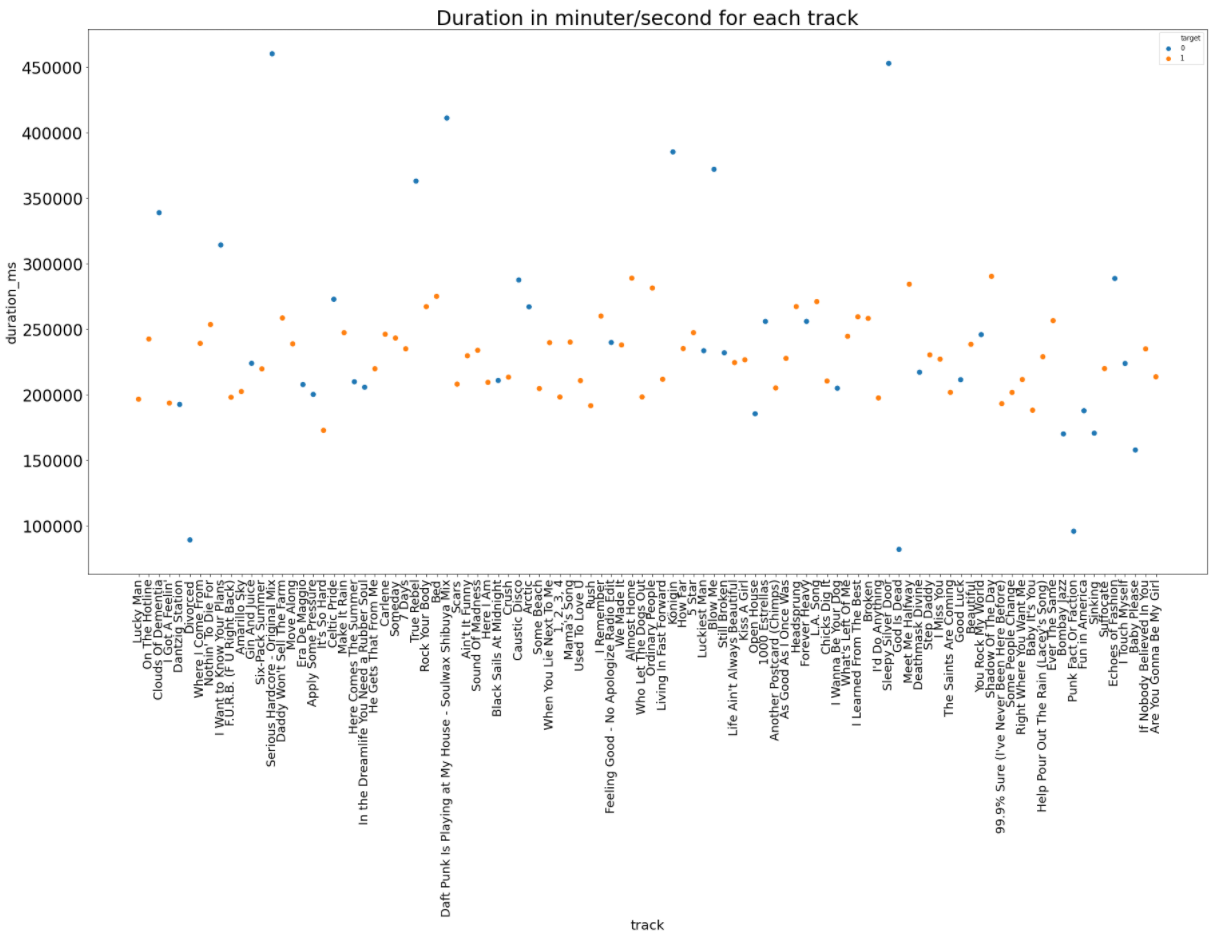

## Text Analysis and Natural Language Processing

We are now ready to explore the lyric data that we have scraped. To begin, we want to remove the words indicating the section of the song (e.g. verse, chorus, bridge, etc.) and any extraneous words or characters that were picked up from the scraping. Once we have removed these unwanted characters, we can further clean the lyrics by removing special characters, applying everything to lowercase, and removing line breaks. With the lyrics suitably cleaned, we can begin data exploration and feature engineering.

### Stop words and N-grams

Stop words are commonly used words (“the”,”a”, “on”, etc.) that do not add much meaning to a corpus, so these are typically removed when proceeding with text analysis. Below are graphics representing the most common stopwords and, conversely, the most common non-stop words.

                                                 Most Common Stop Words
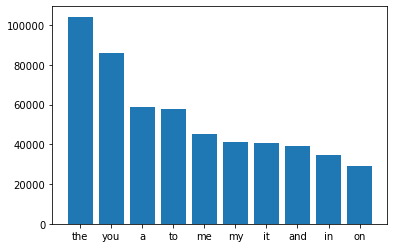

                                                Most Common Non-Stop Words
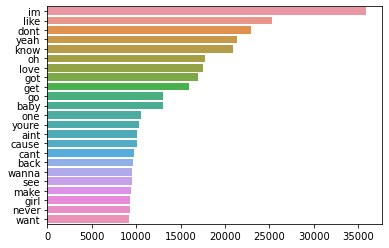

We can also explore the most common N-grams in the corpus. N-grams are combinations of N words/tokens. For example, a two word N-gram could be “Baltimore Orioles.” Below are the most common two and three word N-grams.

                                                Most Common Bi-Grams
 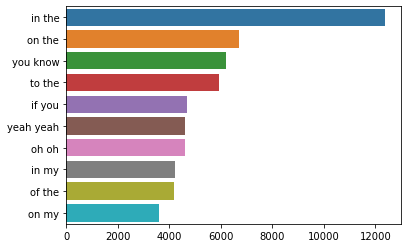

                                                Most Common Tri-Grams
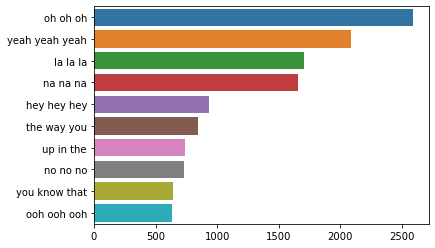

### Repetitiveness

Intuition would suggest that catchy songs are more likely to become popular. If many people have a song stuck in their head, or sing it to themselves often, there is a good chance that the song could have mainstream appeal and be a hit. Songs that have continuously repeated phrases in them are more likely to be catchy, as the more times a person hears a phrase, the more likely they are to remember it. 

In order to measure repetitiveness, we used Colin Morris’ compression technique in his article “Are Pop Lyrics Getting More Repetitive?” When compressing a string, the algorithm will scan the text looking for repeated sequences of characters. Repeated sequences can then be replaced with a single character marker, thus reducing characters and memory. To illustrate this, consider the following lyrics by the Beatles: 

    “​​Get back, get back, Get back to where you once belonged.” 

In these lyrics, the sequence of characters “get back” is repeated multiple times, and thus the compression algorithm would then make the lyrics look like this: 

    “*, *, * to where you once belonged.” 

The phrase “get back” is replaced with a marker. We applied the compression using the Zlib library and measured the repetitiveness of the lyrics by the percentage of memory the lyrics were reduced by.

In [1]:
import zlib  
import binascii
import sys

# Function to calculate compressibility/repetitiveness of song
def calcCompressibility(song):
    data = str(song).encode()
    uncompressedData = zlib.compress(data, 0)
    compressedData = zlib.compress(data, -1)
    return 100*(1-sys.getsizeof(compressedData)/sys.getsizeof(uncompressedData))

#### And here are the most repetitive songs:

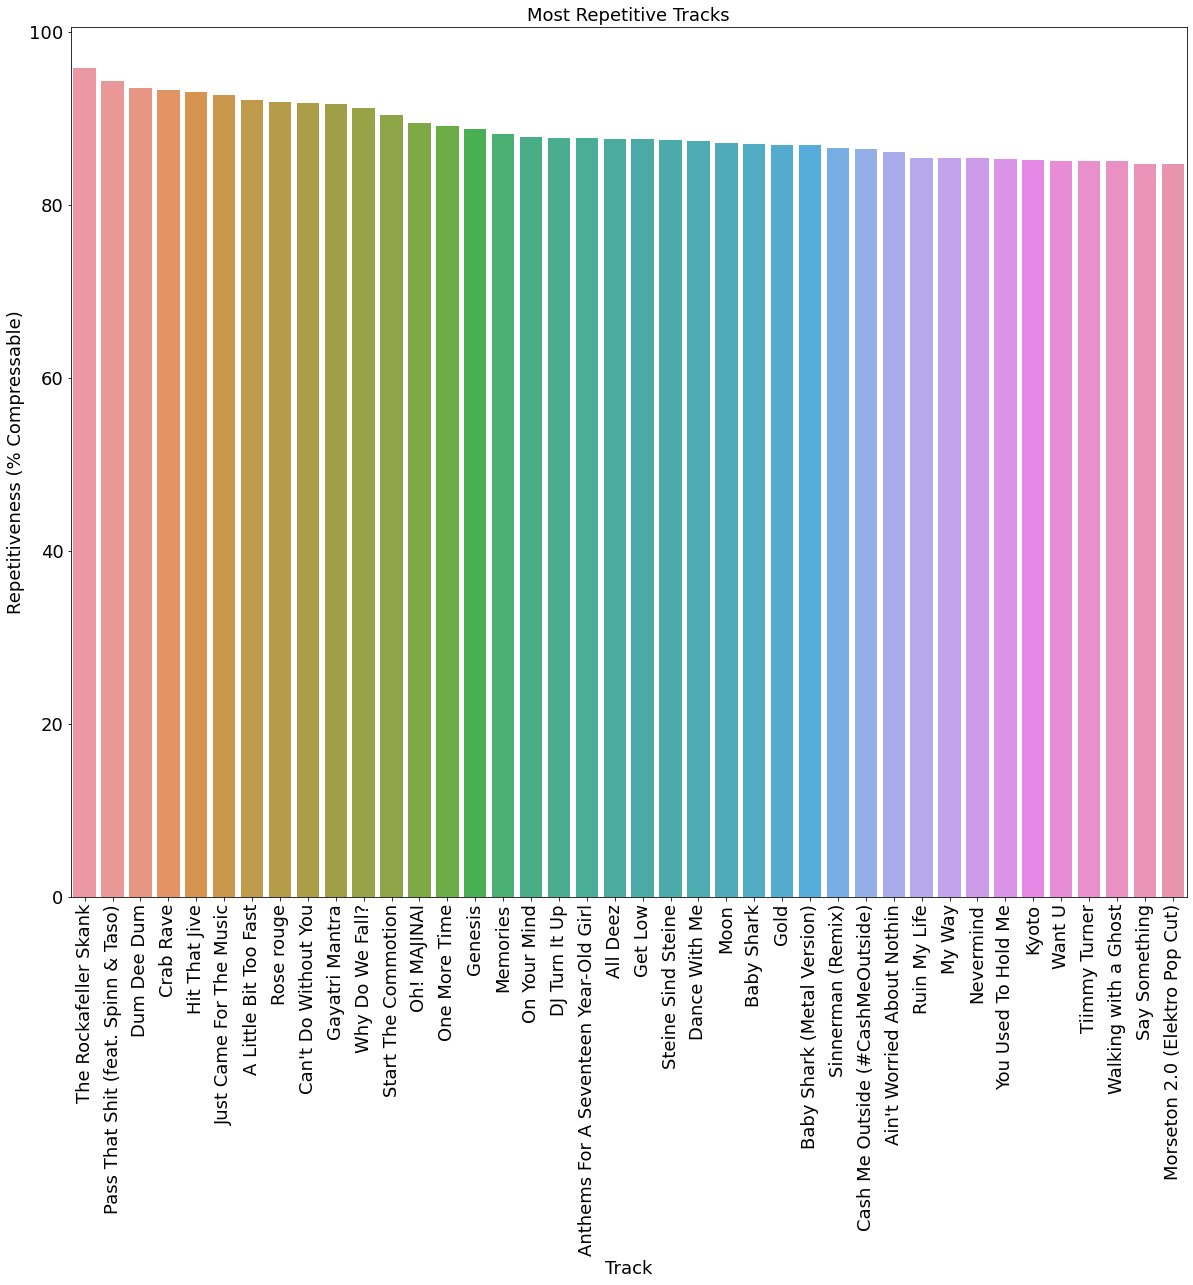

### Average Word Length

For the average word length, we simply counted how many characters were in each word in the lyrics and then averaged the word lengths for the entire song:

In [2]:
# Function to calculate average word length per total song
def avgWordLength(song):
    total_words = len(song.split())
    total_letters = sum([len(a) for a in song.split()])
    return total_letters/total_words

### Polarity

We used the Textblob library to conduct sentiment analysis on all the songs in the dataset. A polarity score between -1 (negative polarity) and 1 (postive polarity) was returned for each song. Textblob uses a rules-based approach to sentiment analysis, which means it searches the lyrics for words it has pre-identified as having either negative, positive, or neutral connotations.

### Word Count

This one is pretty self explanatory. We counted how many words are in each song. This feature is also useful in that we can combine it with our other features, like repetitiveness and song duration. In our model, we will use the repetitiveness multiplied by the word count. This feature shows the balance between the lyric length and how repetitive the lyrics are. We will also use the word count divided by the song duration. This essentially represents how fast the song is sung.

### Average Commonness Score

The average commonness score is a metric designed to see to what extent a song's lyrics are composed of words that are frequently used by other songs in this dataset. To create this metric, we took a word count for every single word that appears in our dataset. We then took the base 10 logarithm of those word counts to make their values smaller. Finally we normalized the transformed word counts. Each word in the dataset now has a commonness score, and for each song, we simply averaged out the commonness scores of all the words in a song's lyrics.

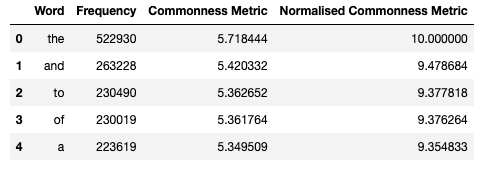

### Topic Modelling

Now that we have these text features, we are ready to prepare the lyrics for topic modelling. In order to prepare the lyrics, we tokenize the lyrics for each song (breaking down the lyrics into its individual words or N-grams), remove all the stop words (since stop words don't add additional meaning), and lemmatize all the words (reducing a word to its stem/lemma so all variations of the word will be treated as the same token). The final step before topic modelling is to vectorize the text. We used term frequency-inverse document frequency (TFIDF), which is a form of word count that more specifically deemphasizes words that appear frequently across all documents. It is a mulitplication of the term frequency by the term's inverse document frequency. With the lyrics vectorized, we can proceed with topic modelling.  

Topic modelling is a way of identifying latent themes in a corpus of documents. Some songs in our dataset might be about love, others might be about money, and others might be about a whole range of other topics. Topic modelling will help us identify what artists are singing about. Since ultimately we are interested in what makes a song a hit, we will conduct the topic modelling on only the hit songs. The specific algorithm we are using for topic modelling is non-negative matrix factorization (NMF). NMF involves decomposing a term frequency or TFIDF matrix into two seperate matrices who's dot product would result in the original matrix. The first matrix is N columns long, corresponding to N number of topics (each column represents a topic). The rows of this matrix represent a single song. The values for each of the columns represent how much a song is made up of that topic. The second matrix's columns represent each unique word in the dataset, and the rows correspond to the topics. The values in this matrix show how much each word contributes to the topic. The below image illustrates this:

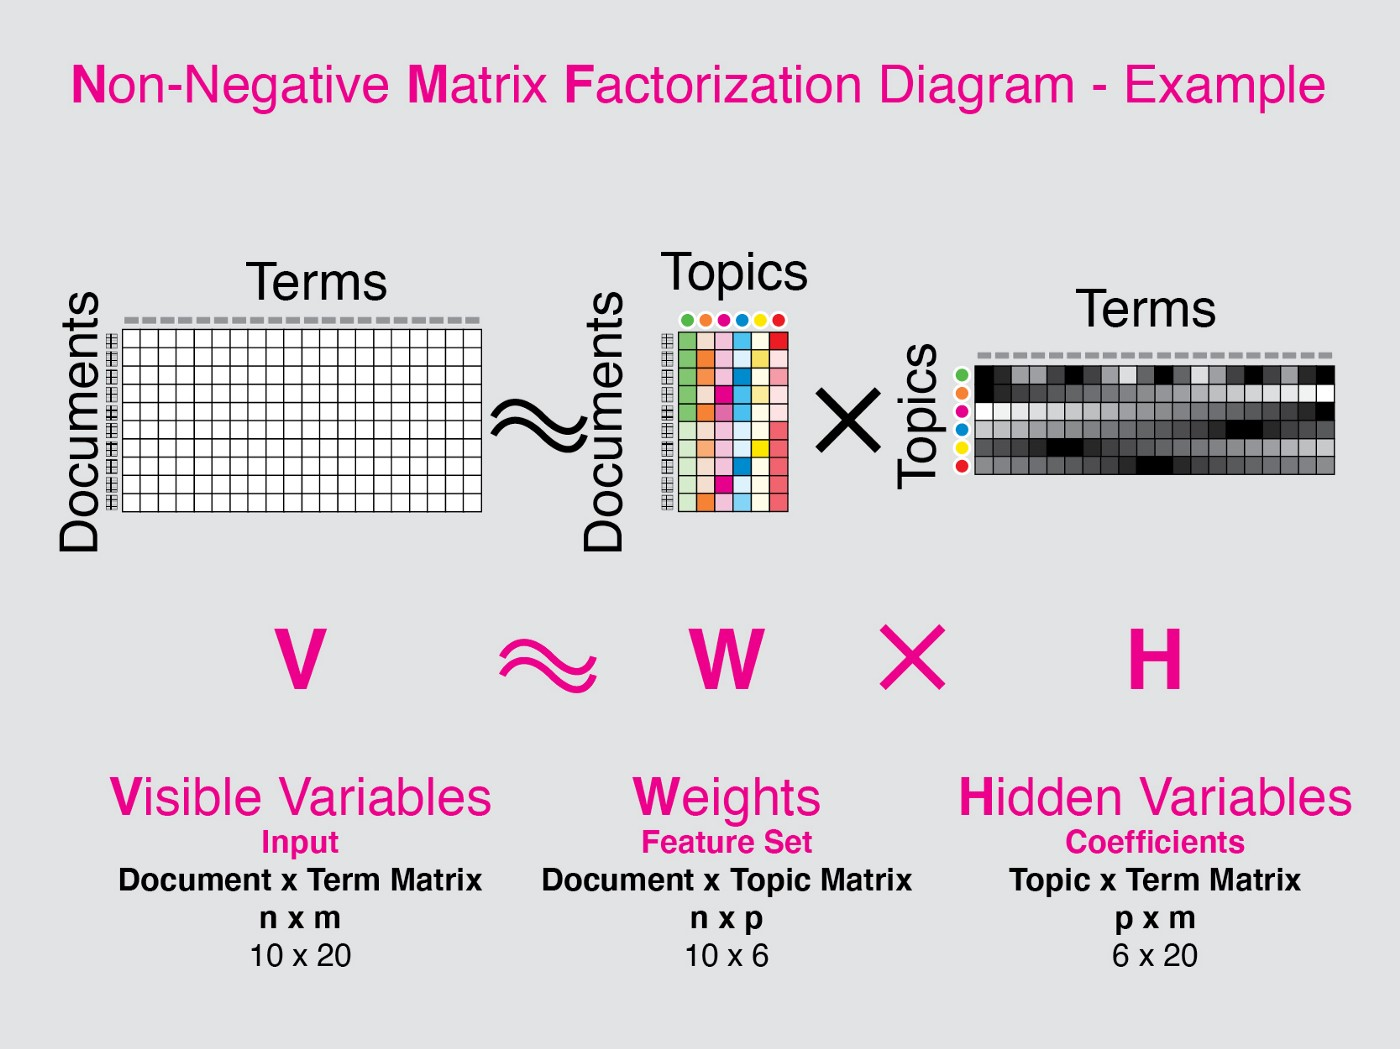
Matrix Decomposition in NMF Diagram Example by [Anupama Garla](https://miro.medium.com/max/1400/1*ru1Ek9T3FjkehDkD8FZoHQ.jpeg)

After some experimenting, we determined that five topics is an ideal number for this dataset. The highest value words for each topic are the following (beware, some of the following lyrics contain profanity):

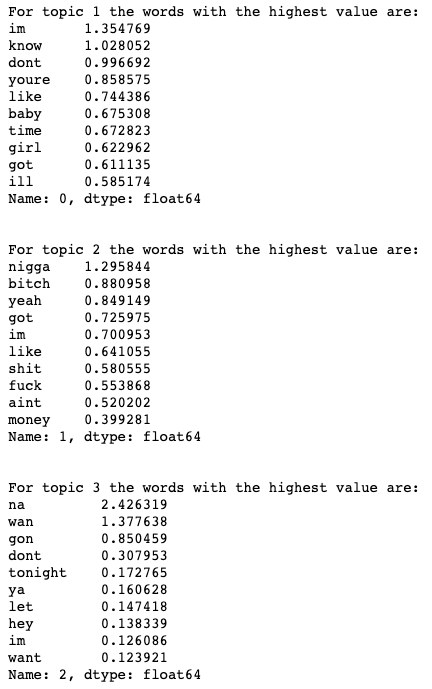

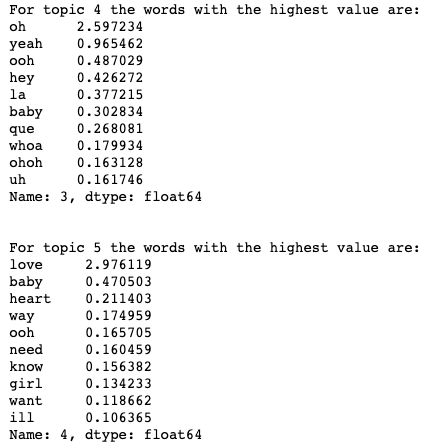

While the topic model results give us an interesting view into what the hit songs are about, we can also use the first decomposed matrix that represents the topic distrubtions for each song as input features for our classification models.

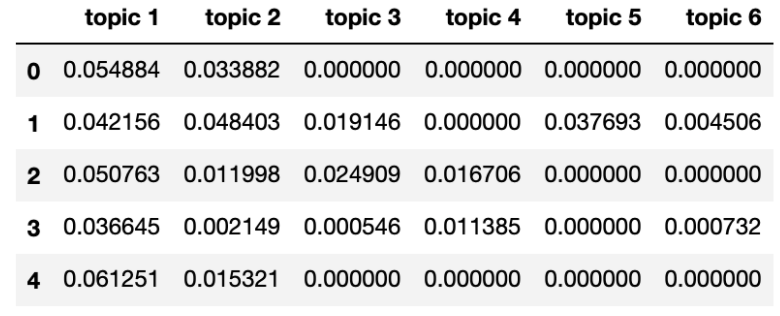

## Modelling

The target variable is whether a song is a hit or a flop.

We are using predictive accoustic features like - (dance, valence, ability, energy, key, loudness, mode, speechiness, acousticness, instrumentalness, liveness, valence, tempo, duration in milliseconds, the time signature, the chorus hits, andsections). We are also using the lyrical features obtained via NLP.

The model was divided into a dataset for training and a dataset for testing. The training dataset size was 0.75 or 75 % and the test size was 0.25 or 25%.

Predicting hit songs is a classification task, so we used classifiers like Logistic Regression, Decision Tree, Random Forest and XGBoost. We wanted to check each of the classifiers and evaluate which one would provide the most acurate predictionss and which ones would perform better in terms of precision, recall and F1 scores. We also evaluated the models with confusion matrices and ROC curves.

**Below is the Confusion matrix for the logistic regression:**

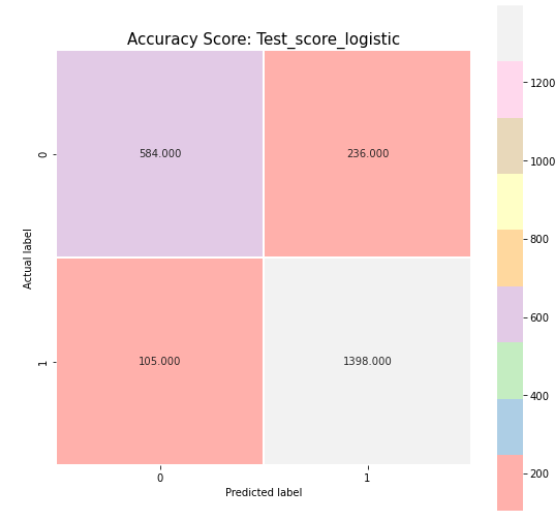

**Results of scores for Logsitic Regression model**

- Accuracy: 0.853

- Precision: 0.856

- Recall: 0.930

- F1: 0.891 

**Model Coefficients**

Attached below is the model coefficients for each of the features. The model coefficients inform us as to which features were most impactful in the logistic regression's predictions. Repetitiveness * Word count has the largest positive coefficient and instrumentalness has the highest negative coefficient, meaning songs with a higher repetitiveness and word count are more likely to be a hit, and songs with a lot of instrumentals are more likely to be a flop.  

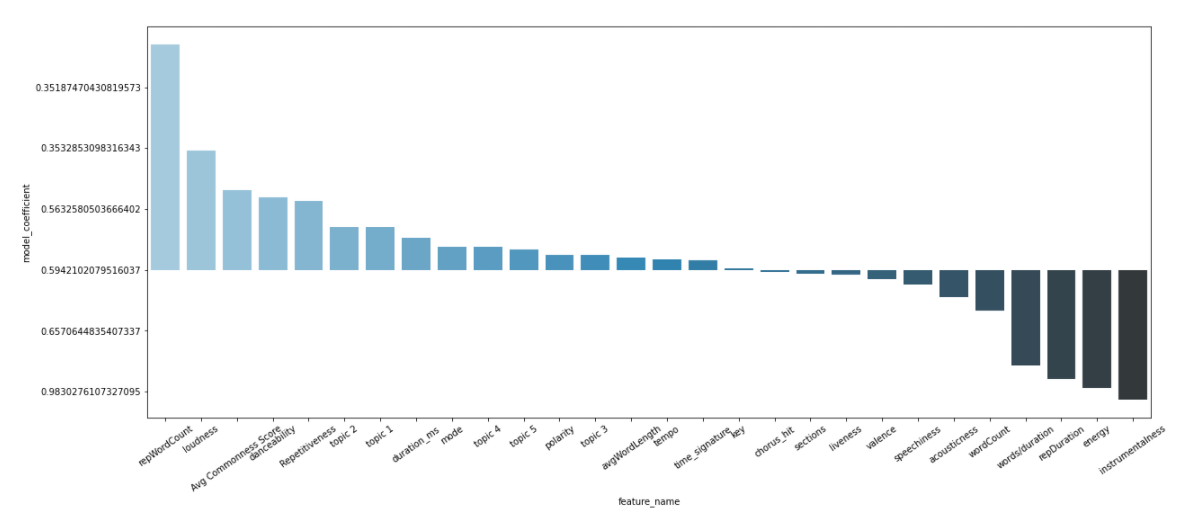

**Below is the Confusion matrix for Decision Tree:**

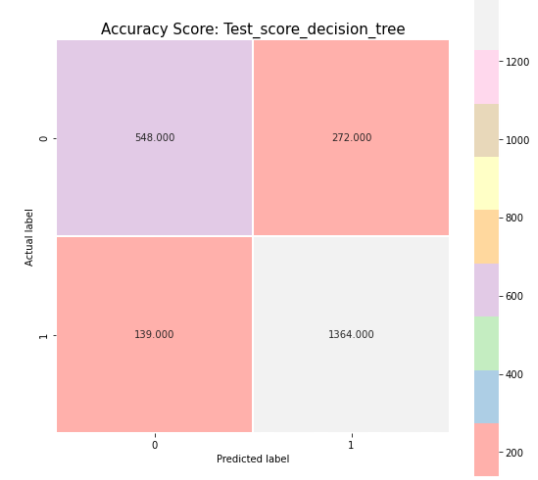

The performance metrics of the decision tree model seems to be sligthly lower than the results for logisitic regression model. 

**Results of scores for Decision Tree model**

- Accuracy: 0.823

- Precision: 0.834

- Recall: 0.908

- F1: 0.869

The performance metrics of the decision tree model seems to be sligthly lower than the results for logisitic regression model. 

**Decision Tree visualization**

We set the max leaf nodes to 10 which means that it woould split the deicion tree into 10 different leaf nodes based on specific conditions within the data. Attached is the visualization of the decision tree. We determined 10 leaf nodes would be appropriate considering the size of the dataset. 

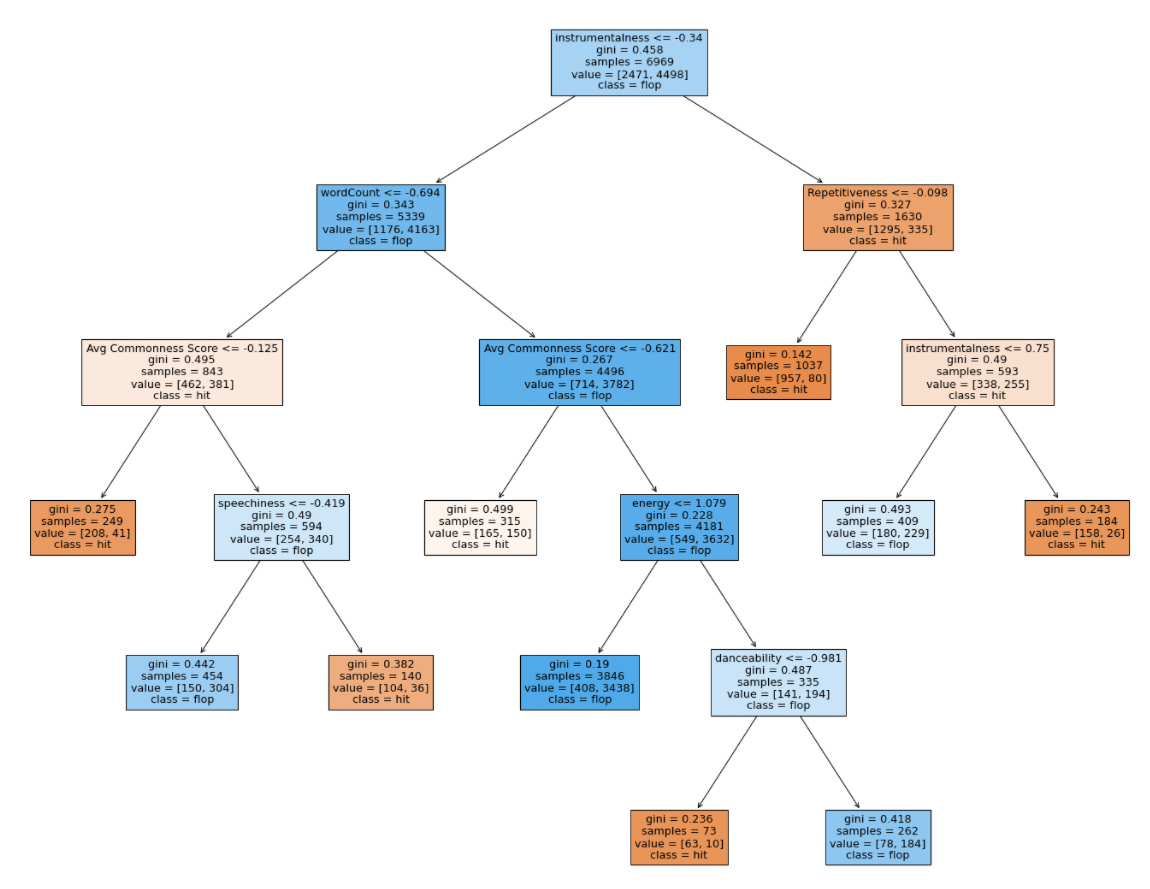


**Results of scores for Random Forest model**

- Accuracy: 0.882

- Precision: 0.888

- Recall: 0.936

- F1: 0.912


**Below is the Confusion matrix for Random Forest:**

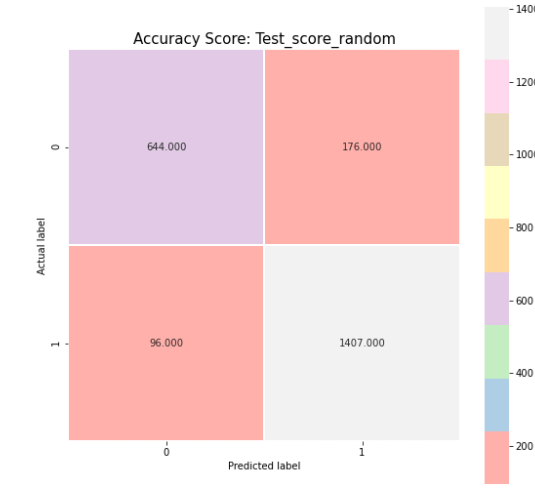

**Feature importance for the Random Forest**

Below is a feature importance chart where the feature importances were generated based on gini impurity. Feature importances, like logistic regression's model coefficients, inform us as to which features played the most impactufl roles in the random forest's predictions. The results show that instrumentalness was the most impactful feature. This is consisten with what we saw in the logistic regression results. 


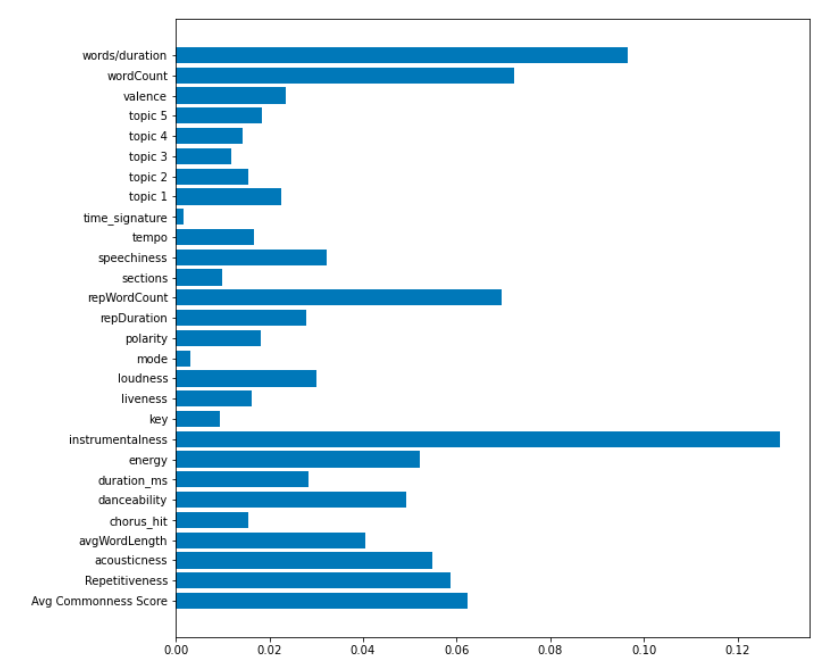


**Results of scores for XGBoost model**

- Accuracy: 0.882

- Precision: 0.888

- Recall: 0.941

- F1: 0.913


**Below is the Confusion matrix for XGBoost model:**

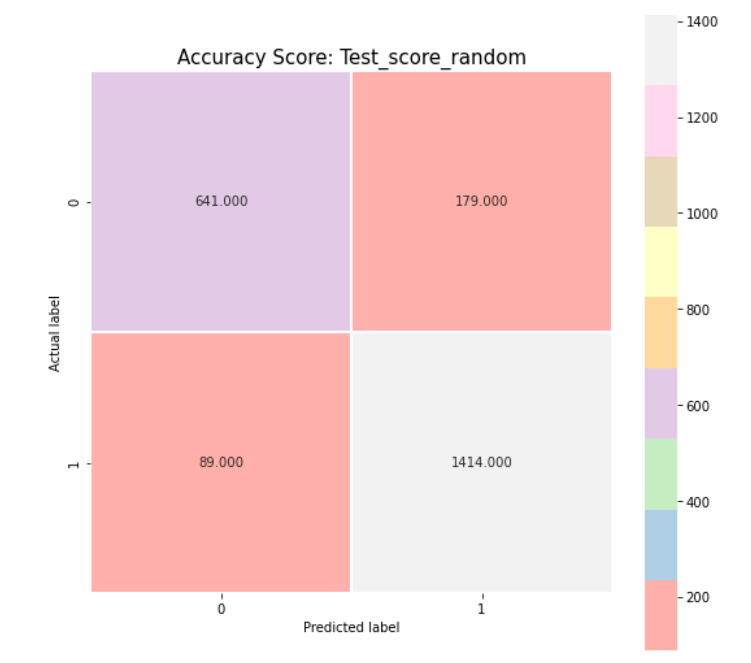

**Below is the Clasification report for XGBoost model:**

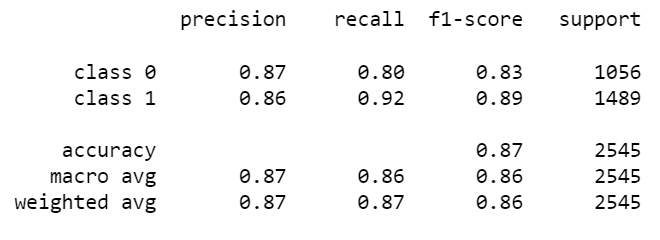

It seems that XGBoost is performaing about the same as random forest, but the recall and the F1 scores are slightly higher. The Random Forest has a AUC score of 0.93 and the XGBoost has a AUC score of 0.94.

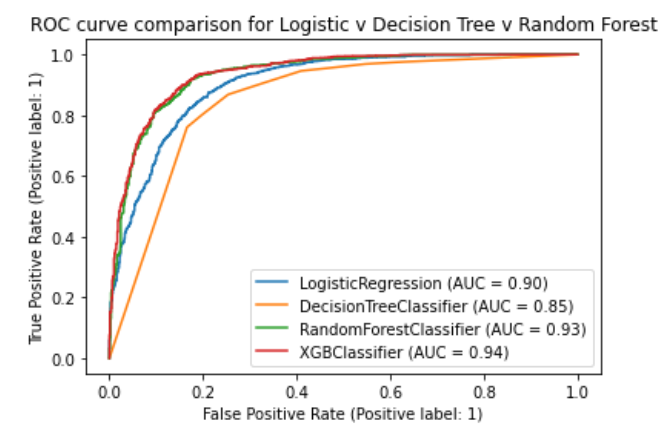

We also developed a voting classsifier that uses an ensemble of logistic regression, decision tree, and XGBoost. The classifier makes its prediction based off of the the class that receives the majority of votes between the three models (e.g. if logistic regression predicted hit, decision tree predicted flop, and XGBoost predicted hit, the model would classify the song as a hit because that was the majority vote).

**Below is the Confusion matrix for Voting Classifier model:**

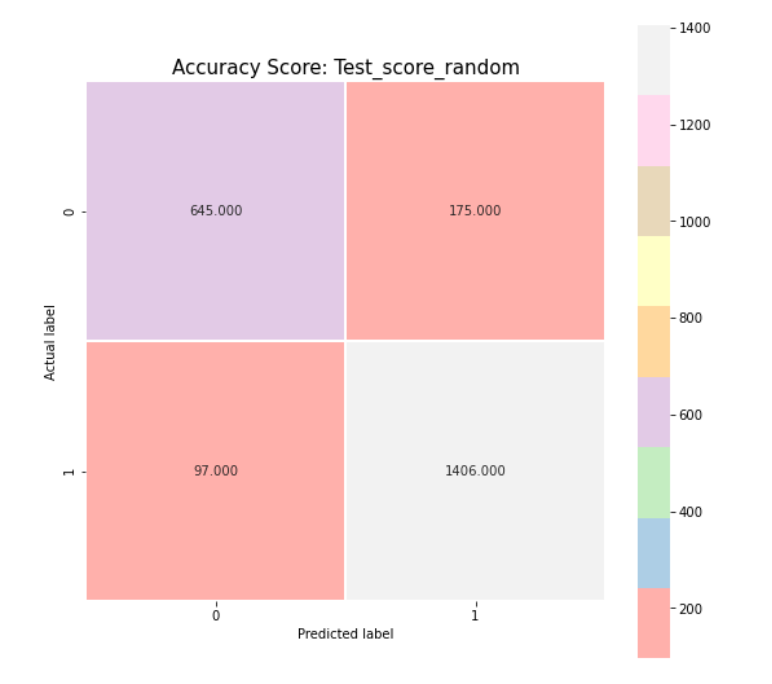

**Results of scores for Voting Classifier model**

- Accuracy: 0.883

- Precision: 0.889

- Recall: 0.935

- F1: 0.912

## Conclusion

We can see that all the models perform meaningfully better than a model that randomly chooses hit or flop based on the 60/40 distribution of the dataset. Additionally, all five models give us very similar results, which validates this approach for hit prediction. The features that most positively impacted a song's ability to be a hit are the repetitiveness times the word count, the loudness, average commonness score, and danceability. People like songs that they can remember (long and repetitive), memorable (loud), do not have complicated words, and are easy to dance to. Conversely, the features that most negatively impact a song's ability to be a hit are the instrumentallness, energy, words/duration, and word count. Songs that are mostly instrumental, have high energy, are sung fast, and are too wordy do not resonate as much with the public.

## Next Steps

There are several areas to expand on this research. Firstly, we could augment this dataset. Our data does not contain every single hit song after 2000. We could scrape more hit songs from after 2000 while also scraping not hit songs to maintain a relatively balanced target distribution. Secondly, we could investigate the comparative predictive strength of Echo Nest features and lyrical features by building a model that isolates only the Echo Nest features and comparing that model's results to the results of a model built on just lyrical features. Thirdly, we could change the target variable to see what else we could use these features to predict. Spotify has its own proprietary popularity metric (that changes over time, as a song's popularity can wane or grow). It might be interesting to see how these features do at predicting that metric or others. Finally, we could conduct the same study, but segment it by genre. What might be popular in one genre might not be popular in other genres. 